# Chain

In [22]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [23]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [24]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [25]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [26]:
result

AIMessage(content='One of the best places to see orcas in the United States is the San Juan Islands in Washington State. The islands are located in the Pacific Northwest and are renowned for their natural beauty and abundant marine life. The prime viewing season for orcas typically spans from late spring to early fall, with peak sightings occurring in the summer months.\n\nThe waters around the San Juan Islands are home to the Southern Resident Killer Whales, a group of orcas that are known for frequenting the area. There are also opportunities to see transient orcas, known as Bigg\'s killer whales, which often hunt seals, porpoises, and other marine life.\n\nSeveral tour operators offer whale-watching excursions from various locations within the San Juan Islands, including Friday Harbor on San Juan Island and other nearby locations. Additionally, Lime Kiln Point State Park on San Juan Island is a popular land-based spot for watching orcas, sometimes referred to as "Whale Watch Park."\

In [27]:
result.response_metadata

{'token_usage': {'completion_tokens': 231,
  'prompt_tokens': 67,
  'total_tokens': 298,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-2024-08-06',
 'system_fingerprint': 'fp_cbf1785567',
 'id': 'chatcmpl-CRCWaKp8h8R6iOYpBeJYeWqrRn3yd',
 'service_tier': 'default',
 'finish_reason': 'stop',
 'logprobs': None}

In [28]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Add a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

llm_with_tools = llm.bind_tools([multiply,add])

In [29]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [30]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_aQESocZWHA8MAh1Exwvlhvjm',
  'type': 'tool_call'}]

In [31]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

In [32]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [33]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    pass

In [34]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='4e99b3d2-ef45-43a4-844a-24c1e90608b6'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='c9aafad8-dfa1-4260-87d5-1edee0a5f1ed'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='d88895db-ec2a-45a5-81d6-37bfb1ac80b9')]

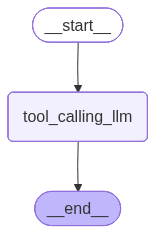

In [35]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today?


In [37]:
messages = graph.invoke({"messages": HumanMessage(content="where is Lamine Yamal from?", name="Lance")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================
Name: Lance

where is Lamine Yamal from?
================================== Ai Message ==================================

Lamine Yamal is from Spain. He was born in Mataró, a city in Catalonia, Spain.


In [38]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_yGO9fLjDUq1BM2e40PRAklj1)
 Call ID: call_yGO9fLjDUq1BM2e40PRAklj1
  Args:
    a: 2
    b: 3


In [39]:
messages = graph.invoke({"messages": HumanMessage(content="Add 9 and 10")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 9 and 10
================================== Ai Message ==================================
Tool Calls:
  add (call_0br0uFmnZLAUrz0TZMXD7tN2)
 Call ID: call_0br0uFmnZLAUrz0TZMXD7tN2
  Args:
    a: 9
    b: 10


In [40]:
messages = graph.invoke({"messages": HumanMessage(content="Add 98 and 107")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 98 and 107
================================== Ai Message ==================================
Tool Calls:
  add (call_5lGP35K757yw3LUxM2HceXy5)
 Call ID: call_5lGP35K757yw3LUxM2HceXy5
  Args:
    a: 98
    b: 107
